# Projet DataMining
Auteur : Evan Tassel, Cyril Recordon  
Date : 2025-02-15  
Version : 1.2


## Initialisation

In [5]:
!pip3 install numpy pandas matplotlib sparqlwrapper

Defaulting to user installation because normal site-packages is not writeable


## Collecte de données  

### Obectifs

Vous devez collecter et télécharger un ensemble d'images. Vous avez les tâches suivantes à programmer, en automatisant le processus autant que possible :

1.  Créer un dossier appelé *images*.
2.  Télécharger les images sous licence ouverte dans le dossier *images* (minimum 100
    images).
3.  Enregistrez les métadonnées de chaque image comme la taille de l'image, le format de l'image (.jpeg,
    .png, etc.), l'orientation de l'image (paysage, portrait, carré, etc.),
    date de création, modèle d'appareil photo, etc. dans un ou plusieurs fichiers JSON. Vous pouvez utiliser les informations [Exif](https://en.wikipedia.org/wiki/Exif) présentes dans les fichiers d'images.

In [6]:
## Imports

import numpy as np
import pandas as pd
import matplotlib as plot
import SPARQLWrapper as sw
import sys
import requests
import shutil
import os
from SPARQLWrapper import SPARQLWrapper, JSON
import json
from PIL import Image
from PIL.ExifTags import TAGS

In [ ]:
## Chargement des requetes

endpoint_url = "https://query.wikidata.org/sparql"

# Code query
query = """SELECT DISTINCT ?gratte_ciel ?gratte_cielLabel ?pays ?paysLabel ?image ?hauteur WHERE {
?gratte_ciel wdt:P31 wd:Q11303;  # Q11303 est l'identifiant pour "gratte-ciel"
            wdt:P17 ?pays;        # Pays
            wdt:P18 ?image;       # Image
            wdt:P2048 ?hauteur.  # Hauteur
SERVICE wikibase:label { bd:serviceParam wikibase:language "fr". }
}
LIMIT 110"""

# Create a SPARQLWrapper object
def get_results(endpoint_url, query):
    user_agent = "WDQS-example Python/%s.%s" % (
        sys.version_info[0],
        sys.version_info[1],
    )
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    return sparql.query().convert()

# Fonction pour télécharger les images
def download_image(url):
    print(f"Téléchargement de : {url}") # debug
    headers = {"User-Agent": "Mozilla/5.0"}
    filename = os.path.join("images", os.path.basename(url))
    request = requests.get(url, allow_redirects=True, headers=headers, stream=True)
    if request.status_code != 200:
        print(f"Erreur de téléchargement : {request.status_code} pour {url}")
    if request.status_code == 200:
        with open(filename, "wb") as image:
            image.write(request.content)
    return request.status_code
    

array = []
results = get_results(endpoint_url, query)

for result in results["results"]["bindings"]:
    if "image" in result :
        array.append(
            (
                result["gratte_cielLabel"]["value"],
                result["paysLabel"]["value"],
                result["image"]["value"],
                result["hauteur"]["value"]
            )
        )

dataframe = pd.DataFrame(array, columns=["gratte_cielLabel", "paysLabel", "image", "hauteur"])
dataframe = dataframe.astype(
    dtype={"gratte_cielLabel": "<U200", "paysLabel": "<U200", "image": "<U200", "hauteur": "float32"}
)
dataframe["image"]

'http://commons.wikimedia.org/wiki/Special:FilePath/Metlife%20building%20from%20empire%20state%20building.jpg'

In [8]:
## Téléchargement des requetes

for url in dataframe["image"]:
    download_image(url)

Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Bankofamerica-atlanta.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Key%20Tower%202022.png
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/T%C3%B2a%20nh%C3%A0%20Keangnam%2C%20C%E1%BA%A7u%20Gi%E1%BA%A5y%2C%20H%C3%A0%20N%E1%BB%99i%20001.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Rose%20Rotana%20Tower%20Under%20Construction%20on%2025%20February%202007%20Pict%202.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Riyadh%20Skyline.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Fbc-ffm001.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/Charlotte%20hearst%20tower.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Special:FilePath/%E4%B8%8A%E6%B5%B7%E7%99%BD%E7%8E%89%E5%85%B0%E5%B9%BF%E5%9C%BA.jpg
Téléchargement de : http://commons.wikimedia.org/wiki/Specia

In [9]:
## Gestion des métadatas dans metadata.json

def convert_value(value):
    """Convertit les valeurs non sérialisables en JSON (IFDRational, bytes, etc.)."""
    if isinstance(value, bytes):
        return value.decode(errors="ignore")  # Convertir en texte
    elif isinstance(value, tuple):
        return tuple(convert_value(v) for v in value)  # Convertir chaque élément d'un tuple
    else:
        return str(value) 

def get_image_metadata(image_path):
    """Récupère les métadonnées d'une image."""
    metadata = {}
    
    try:
        with Image.open(image_path) as img:
            # Taille et format
            width, height = img.size
            metadata["filename"] = os.path.basename(image_path)
            metadata["size"] = f"{width}x{height}"
            metadata["format"] = img.format
            
            # Orientation
            if width > height:
                metadata["orientation"] = "Paysage"
            elif height > width:
                metadata["orientation"] = "Portrait"
            else:
                metadata["orientation"] = "Carré"
            
            # Extraction des métadonnées Exif
            exif_data = img._getexif()
            List_tag = ["filename", "size", "format", "orientation", "GPSInfo", "Make", "Model", "DateTime"]
            if exif_data:
                for tag_id, value in exif_data.items():
                    tag_name = TAGS.get(tag_id, tag_id)  # Convertir ID en nom lisible
                    if tag_name not in List_tag :
                        continue  # Ignorer tout sauf les tags sauf ceux dans List_tag
                    metadata[tag_name] = convert_value(value)
            

    except Exception as e:
        metadata["error"] = str(e)
    
    return metadata

def save_metadata_to_json(folder="images", output_file="metadata.json"):
    """Parcourt toutes les images du dossier et enregistre leurs métadonnées dans un JSON."""
    metadata_list = []
    
    for filename in os.listdir(folder):
        image_path = os.path.join(folder, filename)
        if os.path.isfile(image_path) and filename.lower().endswith(("jpg", "jpeg", "png")):
            metadata = get_image_metadata(image_path)
            metadata_list.append(metadata)
    
    with open(output_file, "w", encoding="utf-8") as json_file:
        json.dump(metadata_list, json_file, indent=4, ensure_ascii=False)
    
    print(f" Métadonnées enregistrées dans le fichier {output_file}")

# Exécuter la fonction
save_metadata_to_json()

 Métadonnées enregistrées dans le fichier metadata.json


## Étiquetage et annotation  

### Objectifs

Pour cette tâche, vous devez rechercher les sources disposant d'informations supplémentaires comme les balises, les catégories, etc.

Dans cette tâche, vous devrez peut-être étiqueter, annoter et enregistrer des informations sur chaque image. Vous pouvez analyser les images en utilisant des algorithmes de regroupement pour trouver les couleurs prédominantes.

Vous disposez déjà de certaines métadonnées provenant de l'EXIF des images de la précédente tâche. Dans cette tâche, votre objectif est d'obtenir des informations supplémentaires, comme les couleurs prédominantes, les tags. Et si vous demandiez aux utilisateurs de tagger les images ? Par exemple, les noms de couleurs, #cat, #fleur, #sous-fleur, rose etc.

Comment prévoyez-vous de traiter ces tags ? Est-il possible d'automatiser ce processus ?

In [10]:
## Imports

import os
import json
import numpy as np
from PIL import Image
from sklearn.cluster import KMeans

In [11]:
## Détection de couleurs principales (le code en dessous marche en soit)



In [12]:
## Code généré par chatgpt, à revoir si on veut l'optimiser (en terme de nombre de couleurs par exemple)

JSON_FILE = "metadata.json"
IMAGE_FOLDER = "images"
N_CLUSTERS = 4  # Nombre fixe de couleurs principales (une méthode de détection automatique prendrait bien plus de temps..)

def load_metadata():
    """Charge le fichier JSON existant ou retourne une liste vide."""
    return json.load(open(JSON_FILE, "r", encoding="utf-8")) if os.path.exists(JSON_FILE) else []

def save_metadata(metadata):
    """Sauvegarde les métadonnées mises à jour."""
    with open(JSON_FILE, "w", encoding="utf-8") as file:
        json.dump(metadata, file, indent=4, ensure_ascii=False)

def extract_colors(image_path):
    """Extrait les 4 couleurs principales d'une image."""
    img = Image.open(image_path).convert("RGB").resize((100, 100))
    pixels = np.array(img.getdata(), dtype=np.uint8)

    kmeans = KMeans(n_clusters=N_CLUSTERS, n_init=5, random_state=42)
    labels = kmeans.fit_predict(pixels)
    histogram = np.bincount(labels)

    sorted_indices = np.argsort(histogram)[::-1]  # Tri décroissant
    return [
        {
            "rgb": tuple(map(int, kmeans.cluster_centers_[idx][:3])),
            "hex": "#%02x%02x%02x" % tuple(map(int, kmeans.cluster_centers_[idx][:3])),
            "percentage": round((histogram[idx] / len(labels)) * 100, 2),
        }
        for idx in sorted_indices
    ]

def update_metadata():
    """Ajoute les couleurs principales aux métadonnées des images."""
    metadata = {meta["filename"]: meta for meta in load_metadata()}

    count = 0
    for filename in os.listdir(IMAGE_FOLDER):
        if filename.lower().endswith(("jpg", "jpeg", "png")):
            count += 1
            image_path = os.path.join(IMAGE_FOLDER, filename)
            print(f"Analyse de {filename}...")
            metadata[filename]["colors"] = extract_colors(image_path)

    save_metadata(list(metadata.values()))
    print("Nombre d'images analysées en terme de couleurs : ",count)

update_metadata()

Analyse de Shin%20Marunouchi%20Bldg.jpg...
Analyse de 20090518%20Trump%20International%20Hotel%20and%20Tower%2C%20Chicago.jpg...
Analyse de Two%20Logan%20Square.jpg...
Analyse de 15%20Park%20Row%203.JPG...
Analyse de Bankofamerica-atlanta.jpg...
Analyse de BahnTower%2C%20Potsdamer%20Platz%2C%20Berin-1750.jpg...
Analyse de Pirelli%20tower%20%2827559885391%29.jpg...
Analyse de HSBC%20Building%20London.jpg...
Analyse de 1%20Canada%20Square%20From%20Cabot%20Square.jpg...
Analyse de Messe-Torhaus%2C%20Frankfurt.jpg...
Analyse de 2Prud.jpg...
Analyse de New%20York%20-%20Manhattan%20-%20Plaza%20Hotel.jpg...
Analyse de WHITE%20SWAN%20HOTEL%20%282017-10-14%29.jpg...
Analyse de Sunshine%2060%20Ikebukuro%20Tokyo%2020070304-03.jpg...
Analyse de Fbc-ffm001.jpg...
Analyse de NRW%2C%20Cologne%20-%20Mediapark%2C%20KolnTurm%202.jpg...
Analyse de POL%20Warszawa%20Cosmopolitan%2001.jpg...
Analyse de Industriequartier%20-%20Prime%20Tower%202011-08-08%2013-44-40.JPG...
Analyse de Carlton%20Centre%202.jpg..

/home/evan/.local/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Analyse de Frankfurt%20Am%20Main-Westend%20Tower-Ansicht%20vom%20Maintower.jpg...
Analyse de Nauru%20House%20AON.jpg...
Analyse de Palacio%20Barolo%2010.jpg...
Analyse de Torre%20Cepsa%20%28Madrid%29%2001.jpg...
Analyse de ContinentalHQHoustonTX.JPG...
Analyse de Commerce%20Place%2010.jpg...
Analyse de Sherman%20%26%20Plaza%20Hotel%20uncut%20jeh.jpg...
Analyse de 2004-09-08%201600x2840%20chicago%20prudentials.jpg...
Analyse de Carnegie%20Hall%20Tower.JPG...
Analyse de Metropolitan%20Life%20Insurance%20Tower%2C%202024.jpg...
Analyse de Columbia%20center%20from%20smith%20tower.jpg...
Analyse de Tomorrow%20Square.jpg...
Analyse de Shenzhen%20Special%20Zone%20Press%20Tower2020.jpg...
Analyse de Aon%20Center%20LA.jpg...
Analyse de Philadelphia-CityHall-2006.jpg...
Analyse de Mannheim%20Collini-Center%2020100809.jpg...
Analyse de Chase%20Tower%2C%20a%20block%20away.jpg...
Analyse de Mediapark%20K%C3%B6lnTurm%20%280508-10%29.jpg...
Analyse de Construction%20site%20of%20Busan%20Lotte%20Tower.j

/home/evan/.local/lib/python3.10/site-packages/sklearn/base.py:1389: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  return fit_method(estimator, *args, **kwargs)


Analyse de 011%20Shell%20Centre%20-%20global%20headquarters%20of%20Shell%20plc%20oil%20company%20in%20London%20UK.jpg...
Analyse de Al%20Hamra%20Kuwait%20Mai%202010.jpg...
Nombre d'images analysées en terme de couleurs :  108


In [ ]:
import os
import json
import ipywidgets as widgets
from IPython.display import display
from PIL import Image

# Fichier JSON des favoris
FAVORITES_FILE = "favorites.json"
IMAGE_FOLDER = "images"

# Charger les favoris existants ou créer un fichier vide
def load_favorites():
    if os.path.exists(FAVORITES_FILE):
        with open(FAVORITES_FILE, "r", encoding="utf-8") as file:
            return json.load(file)
    return {"favorites": []}

def save_favorites(data):
    with open(FAVORITES_FILE, "w", encoding="utf-8") as file:
        json.dump(data, file, indent=4, ensure_ascii=False)

# Demande le nom de l'utilisateur
user_name = input("Entrez votre nom d'utilisateur : ").strip()

# Charger les images du dossier
image_files = [f for f in os.listdir(IMAGE_FOLDER) if f.lower().endswith(("jpg", "jpeg", "png"))]

# Widgets pour sélectionner les favoris et ajouter des tags
checkboxes = [widgets.Checkbox(value=False, description="Favori") for _ in image_files]
tag_inputs = [widgets.Text(placeholder="Ajoutez des tags séparés par des virgules") for _ in image_files]

# Création de l'affichage
grid = widgets.VBox([])
for img_file, checkbox, tag_input in zip(image_files, checkboxes, tag_inputs):
    image_path = os.path.join(IMAGE_FOLDER, img_file)
    
    # Afficher l'image en taille correcte
    with Image.open(image_path) as img:
        img.thumbnail((150, 150))  # Ajuster la taille
        img_widget = widgets.Image(value=open(image_path, "rb").read(), format='png', width=150, height=150)
    
    grid.children += (widgets.HBox([img_widget, checkbox, tag_input]),)

# Bouton pour enregistrer les favoris
save_button = widgets.Button(description="Enregistrer les favoris")
output = widgets.Output()

# Fonction pour enregistrer la sélection
def save_selection(_):
    favorites_data = load_favorites()

    for img_file, checkbox, tag_input in zip(image_files, checkboxes, tag_inputs):
        if checkbox.value:  # Image cochée comme favorite
            tags = [tag.strip() for tag in tag_input.value.split(",") if tag.strip()]
            
            # Vérifier si l'image est déjà en favoris
            existing_entry = next((fav for fav in favorites_data["favorites"] if fav["filename"] == img_file), None)

            if existing_entry:
                # Ajouter ou mettre à jour les tags pour cet utilisateur
                existing_entry["users"][user_name] = tags
            else:
                # Nouvelle entrée
                favorites_data["favorites"].append({
                    "filename": img_file,
                    "users": {user_name: tags}
                })

    # Sauvegarde dans le fichier JSON
    save_favorites(favorites_data)

    # Affichage du résultat
    with output:
        output.clear_output()
        print(f"Favoris enregistrés pour {user_name} !")

# Associer la fonction au bouton
save_button.on_click(save_selection)

# Affichage dans Jupyter
display(grid, save_button, output)


Button(description='Enregistrer les favoris', style=ButtonStyle())

Output()

## Analyses de données

Demandez à l'utilisateur de sélectionner quelques images et d'ajouter des balises. Pour chaque utilisateur, vous êtes
maintenant prêt à construire un profil de préférences d'utilisateur, basé sur cette sélection.
Vous pouvez recueillir les informations suivantes manuellement, mais l'objectif de
cette tâche consiste à les obtenir en utilisant les images sélectionnées de manière automatisée : 

1.  Couleurs préférées
2.  Orientation de l'image préférée
3.  Tailles d'images préférées (vignettes, grandes images, images de taille moyenne
    images, etc.)
4.  Balises favorites

Maintenant, grâce à votre connaissance des différents types de classificateurs et
les algorithmes de regroupement, quelles informations supplémentaires ajouterez-vous pour chaque
image ?

Votre prochain objectif est d'analyser les informations des utilisateurs et leurs images préférées. Comment avez-vous créé des utilisateurs aléatoires ? Combien d'utilisateurs avez-vous
créer ? Quelles informations avez-vous stockées pour chaque utilisateur ? Quels types d'analyses avez-vous effectuées ?

In [14]:
## A faire c'est du bordel
import math

## Nombre d'images dans le dossier image
with open("metadata.json", "r", encoding="utf-8") as file:
    data = json.load(file)
nbr_images = len(data)

## Demander à l'utilisateur de sélectionner quelques images et d'y ajouter des balises

L_numero_images = []
flag = True
while (flag == True) :
    image = input("Choisissez le numéro d'une image à sélectionner : ('0' pour finir)")
    if int(image) == 0 :
        flag = False
    elif image.isdigit() :
        if int(image) < nbr_images : 
            L_numero_images.append(int(image))
        else :
            print("Numéro d'image inexistant.")
    else :
        print("Image non reconnue, veuillez mettre le numéro de l'image ou '0' pour terminer.")
print(L_numero_images)


## Demander à l'utilisateur sa/ses couleurs préférées, si possible à automatiser à partir des images choisies avant.

# En demandant à l'utilisateur de remplir lui même : 
"""L_couleur = []
couleur = ""
while couleur != "n" : 
    couleur = input("Quelle est votre couleur préférée ? Une à la fois ('n' pour NONE ou NO MORE)")
    if couleur == "n" : 
        continue
    L_couleur.append(couleur)
print(L_couleur)"""


[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30]


'L_couleur = []\ncouleur = ""\nwhile couleur != "n" : \n    couleur = input("Quelle est votre couleur préférée ? Une à la fois (\'n\' pour NONE ou NO MORE)")\n    if couleur == "n" : \n        continue\n    L_couleur.append(couleur)\nprint(L_couleur)'

## Visualisation des données

Dans cette tâche, votre objectif est de visualiser les différentes caractéristiques de
toutes les images téléchargées.

1.  Le nombre d'images disponibles pour chaque année
2.  Le nombre d'images disponibles pour les différents types : taille de l'image,
    l'orientation des images, les modèles d'appareils photo, etc. 
3.  Caractéristiques des couleurs

Les utilisateurs peuvent également visualiser les informations ci-dessus relatives à leurs images préférées. Dans cette tâche, vous devez également ajouter une fonctionnalité permettant aux utilisateurs de visualiser les informations liées à leur propre profil d'utilisateur.

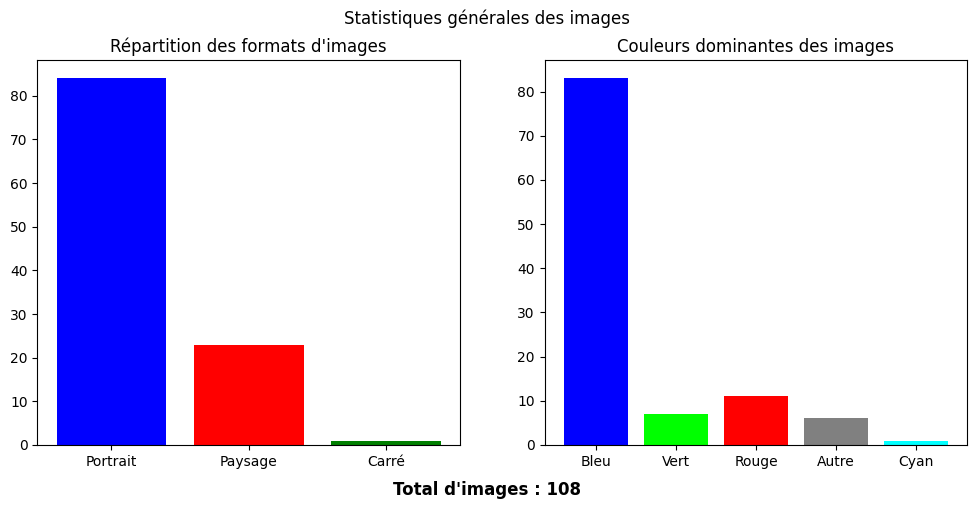

In [15]:
import json
import os
import matplotlib.pyplot as plt
from collections import Counter

# Fichiers utilisés
METADATA_FILE = "metadata.json"
FAVORITES_FILE = "favorites.json"

# Charger les métadonnées des images
def load_metadata():
    if os.path.exists(METADATA_FILE):
        with open(METADATA_FILE, "r", encoding="utf-8") as file:
            return json.load(file)
    return []

# Charger les favoris
def load_favorites():
    if os.path.exists(FAVORITES_FILE):
        with open(FAVORITES_FILE, "r", encoding="utf-8") as file:
            return json.load(file)
    return {"favorites": []}

# Fonction pour regrouper les couleurs principales
def categorize_color(rgb):
    """Associe une couleur RGB à une grande catégorie"""
    r, g, b = rgb
    if r > g and r > b:
        return "Rouge", "#FF0000"
    elif g > r and g > b:
        return "Vert", "#00FF00"
    elif b > r and b > g:
        return "Bleu", "#0000FF"
    elif abs(r - g) < 30 and r > b:
        return "Jaune", "#FFFF00"
    elif abs(r - g) < 30 and b > r:
        return "Cyan", "#00FFFF"
    elif abs(r - b) < 30 and g > r:
        return "Vert clair", "#90EE90"
    else:
        return "Autre", "#808080"

# Analyser les métadonnées
def analyze_images():
    metadata = load_metadata()

    format_counter = Counter()
    color_counter = Counter()
    color_map = {}

    for data in metadata:
        format_counter[data["orientation"]] += 1

        if "colors" in data:
            dominant_color = data["colors"][0]["rgb"]
            category, hex_color = categorize_color(dominant_color)
            color_counter[category] += 1
            color_map[category] = hex_color  # Associer la catégorie à sa couleur

    return format_counter, color_counter, color_map, len(metadata)  # Ajout du nombre total d'images

# Générer les stats par utilisateur
def analyze_all_users():
    metadata = {meta["filename"]: meta for meta in load_metadata()}
    favorites = load_favorites()["favorites"]

    user_stats = {}

    for fav in favorites:
        for user in fav["users"]:
            if user not in user_stats:
                user_stats[user] = {
                    "format_counter": Counter(),
                    "color_counter": Counter(),
                    "color_map": {},
                    "image_count": 0  # Compteur d'images favorites
                }

            filename = fav["filename"]
            if filename in metadata:
                user_stats[user]["format_counter"][metadata[filename]["orientation"]] += 1
                user_stats[user]["image_count"] += 1  # Incrémenter le compteur d'images favorites

                if "colors" in metadata[filename]:
                    dominant_color = metadata[filename]["colors"][0]["rgb"]
                    category, hex_color = categorize_color(dominant_color)
                    user_stats[user]["color_counter"][category] += 1
                    user_stats[user]["color_map"][category] = hex_color

    return user_stats

# Affichage des stats avec matplotlib
def plot_stats(format_counter, color_counter, color_map, title, total_images=None, fav_images=None):
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Graphique des orientations
    axes[0].bar(format_counter.keys(), format_counter.values(), color=["blue", "red", "green"])
    axes[0].set_title("Répartition des formats d'images")

    # Graphique des couleurs dominantes
    colors = list(color_counter.keys())
    values = list(color_counter.values())
    hex_colors = [color_map[color] for color in colors]  # Associer chaque barre à sa couleur

    axes[1].bar(colors, values, color=hex_colors)
    axes[1].set_title("Couleurs dominantes des images")

    # Ajouter un texte avec le nombre total d'images
    if total_images is not None:
        fig.text(0.5, 0.01, f"Total d'images : {total_images}", ha='center', fontsize=12, fontweight='bold')

    if fav_images is not None:
        fig.text(0.5, -0.05, f"Images en favoris : {fav_images}", ha='center', fontsize=12, fontweight='bold')

    plt.suptitle(title)
    plt.show()

# Exécuter les stats générales
format_stats, color_stats, color_map, total_images = analyze_images()
plot_stats(format_stats, color_stats, color_map, "Statistiques générales des images", total_images=total_images)

# Exécuter les stats pour tous les utilisateurs
user_stats = analyze_all_users()
for user, stats in user_stats.items():
    plot_stats(stats["format_counter"], stats["color_counter"], stats["color_map"], 
               f"Statistiques des images favorites de {user}", fav_images=stats["image_count"])


## Système de recommandation

Êtes-vous maintenant prêt à recommander des images à un utilisateur ? Dans cette tâche, votre objectif est de construire le système de recommandation. Quelle approche avez-vous décidé de prendre ? Filtrage collaboratif, basé sur le contenu ou une approche hybride ? Quel(s) algorithme(s) avez-vous choisi (classification, clustering, ...) ? Pour chaque utilisateur, êtes-vous maintenant en mesure de construire une profil ? Quel type d'information avez-vous utilisé pour établir un profil d'utilisateur profil ? Qu'est-ce qui manque ? Quelles sont les limites de votre proposition ?

In [16]:
## A faire




## Tests

Votre prochaine tâche consiste à mettre au point et à effectuer différents tests sur votre proposition système. Les différentes fonctions sont-elles fonctionnelles ? Comment avez-vous testé votre projet ? Comment vérifiez-vous que votre système de recommandation fonctionne ?